In [77]:
%matplotlib inline
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP, MLP_w
from utils.preprocessing import split,Normalize
from utils.losses import MSE, MEE

In [78]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
np.random.shuffle(raw_data)

input_data=raw_data[:,1:-2]
input_labels=raw_data[:,-2:]

frac_test=0.15
data, test_set, labels, test_labels = split(input_data, input_labels, 
                                            kind="hold_out",frac_training=1-frac_test)

In [6]:
import utils.grid_search
importlib.reload(utils.grid_search)
from utils.grid_search import grid_search

# Structure to test: 
n_feat = np.shape(labels)[1]
model1 = {'structure':[10, n_feat], 'func':['sigmoid', 'linear'], 'starting_points': [0.5]*2}
model2 = {'structure':[15, n_feat], 'func':['sigmoid', 'linear'], 'starting_points': [0.5]*2}
model3 = {'structure':[20, n_feat], 'func':['sigmoid', 'linear'], 'starting_points': [0.5]*2}
model5= {'structure':[4,4, n_feat], 'func':['sigmoid','sigmoid','linear'], 'starting_points': [0.5]*2}
model4 = {'structure':[5,4,n_feat], 'func':['sigmoid','sigmoid','linear'],'starting_points': [0.5]*2}
model6 = {'structure':[6,6,n_feat], 'func':['sigmoid','sigmoid','linear'],'starting_points': [0.5]*2}
models = [model1, model2, model3, model4, model5, model6]
dict_models = {f'Model{i}': m for i, m in enumerate(models)} 

list_eta = [1e-2,5e-3,1e-3,5e-4,1e-4]
list_alpha = np.arange(0,0.3,0.1)
list_lamb = np.arange(0,0,1) ; list_beta = np.arange(0.6,1,0.1)
dict_params = {'eta':list_eta, 'alpha':list_alpha, 'lamb':list_lamb, 'epoch':[1000], 'RMSProp' : [True], 'nesterov' : [True,False] , 'beta' : list_beta }

grid_results = grid_search(MLP_w, dict_models, dict_params, 
                           data, labels, MEE,
                           verbose = 1, kind = 'k_fold', k = 4)

0 on 7200: Model Model0 --> Train parameters: {'eta': 0.01, 'alpha': 0.0, 'lamb': 0.0, 'epoch': 1000, 'RMSProp': True, 'nesterov': True, 'beta': 0.6}
Epoch 1000:  [train MEE = 1.2121]  [val MEE = 1.3139]                              
Elapsed time: 8.33719778060913 s
Epoch 1000:  [train MEE = 1.2300]  [val MEE = 1.2760]                              
Elapsed time: 7.849121332168579 s
Epoch 1000:  [train MEE = 1.1836]  [val MEE = 1.2347]                              
Elapsed time: 7.590497970581055 s
Epoch 1000:  [train MEE = 1.2189]  [val MEE = 1.2880]                              
Elapsed time: 7.635863542556763 s


1 on 7200: Model Model0 --> Train parameters: {'eta': 0.01, 'alpha': 0.0, 'lamb': 0.0, 'epoch': 1000, 'RMSProp': True, 'nesterov': True, 'beta': 0.7}
Epoch 1000:  [train MEE = 1.2183]  [val MEE = 1.3070]                              
Elapsed time: 7.942722320556641 s
Epoch 1000:  [train MEE = 1.2001]  [val MEE = 1.2915]                              
Elapsed time: 7.822643518

KeyboardInterrupt: 

In [ ]:
grid_results[0]

{'train': {'eta': 0.01,
  'alpha': 0.1,
  'lamb': 0.0001,
  'epoch': 10000,
  'RMSProp': True,
  'n_candidate': 3,
  'test_more_init': True,
  'patience': 100,
  'error_threshold': 0.001},
 'model': {'structure': [20, 2],
  'func': ['sigmoid', 'linear'],
  'starting_points': [0.5, 0.5]},
 'model_name': 'Model0',
 'Error': 1.2707461751853686}

In [98]:
frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                               frac_training=frac_training)
best_model_dict = grid_results[0]
best_model_dict['model']
best_model = MLP(**best_model_dict['model'])
train_dict = dict(best_model_dict['train'])
del train_dict['n_candidate']
del train_dict['test_more_init']

In [107]:
best_model.train(input_data, train_labels, val_data, val_labels, **train_dict)

Epoch 3004:  [train MEE = 1.0399]  [val MEE = 1.1968]                              
Elapsed time: 1.4389400482177734 s


In [108]:
def plot_results(network, input_data, val_data, labels, val_labels):
    train_pred = network.predict(input_data)
    val_pred = network.predict(val_data)
    x = np.arange(len(network.train_MEE))

    fig = plt.figure(figsize=(13,4))

    fig.add_subplot(131)
    plt.plot(x,network.train_MEE)
    plt.plot(x,network.val_MEE,label="test")
    plt.title("Learning curve")
    plt.xlabel("Epochs")
    plt.ylabel("Squared error")
    plt.yscale("log")
    plt.legend()

    fig.add_subplot(132)
    plt.title('Residual for training data')
    plt.plot(np.arange(len(labels)),labels[:,0]-train_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(labels)),labels[:,1]-train_pred[:,1],".",label="residual1")
    plt.legend()

    fig.add_subplot(133)
    plt.title('Residual for validation data')
    plt.plot(np.arange(len(val_labels)),val_labels[:,0]-val_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(val_labels)),val_labels[:,1]-val_pred[:,1],".",label="residual1")
    plt.legend()
    plt.tight_layout()
    plt.show()

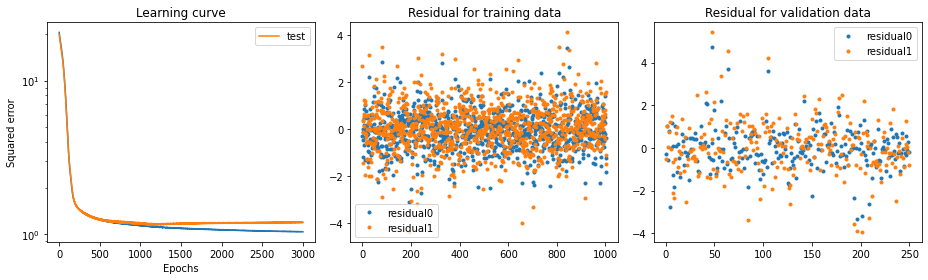

In [109]:
plot_results(best_model, input_data, val_data, train_labels, val_labels)